# Prediction customer churn

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE, RandomOverSampler

sns.set_theme(style = 'dark', palette="pastel")

## 1. EDA

In [2]:
df = pd.read_csv('../../../data/Telco-Customer-Churn.csv', index_col='customerID')

In [3]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
#TotalCharges should be numeric
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [7]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
df = df.dropna()
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

<AxesSubplot:>

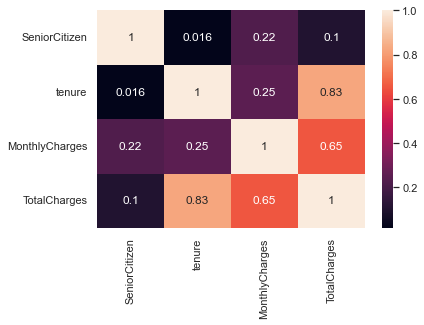

In [10]:
sns.heatmap(df.corr(), annot=True)

In [11]:
#As TotalCharges is strongly correlated to both tenure and MonthlyCharges, we'll take it out to avoid multicollinearity
df = df.drop('TotalCharges', axis = 1)

<AxesSubplot:xlabel='Churn', ylabel='count'>

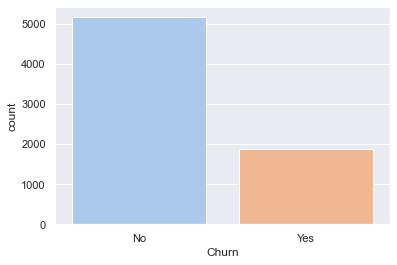

In [14]:
#Churn is out target variable, let's check the distribution

sns.countplot(x=df.Churn)

We have much more non-churners than churners which can influence our results. We will have to deal with it later by Oversampling.

In [69]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [20]:
def churn_plot(ax, column):
    sns.countplot(x=column, hue='Churn', data=df, ax=ax)
    ax.set_title('Churn by ' + column)

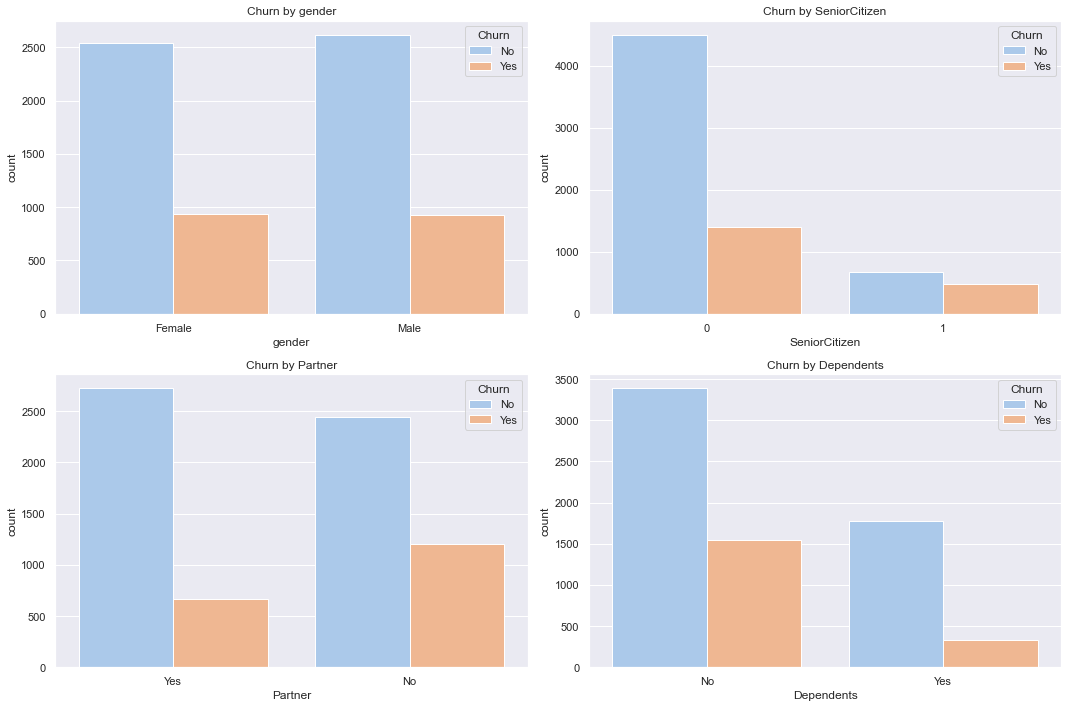

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))
churn_plot(ax1,'gender')
churn_plot(ax2,'SeniorCitizen')
churn_plot(ax3,'Partner')
churn_plot(ax4,'Dependents')

plt.tight_layout()


In the demographics, gender does not seem to have an impact on churn rate. Senior citizens are more likely to churn, as are singles and people without dependents.

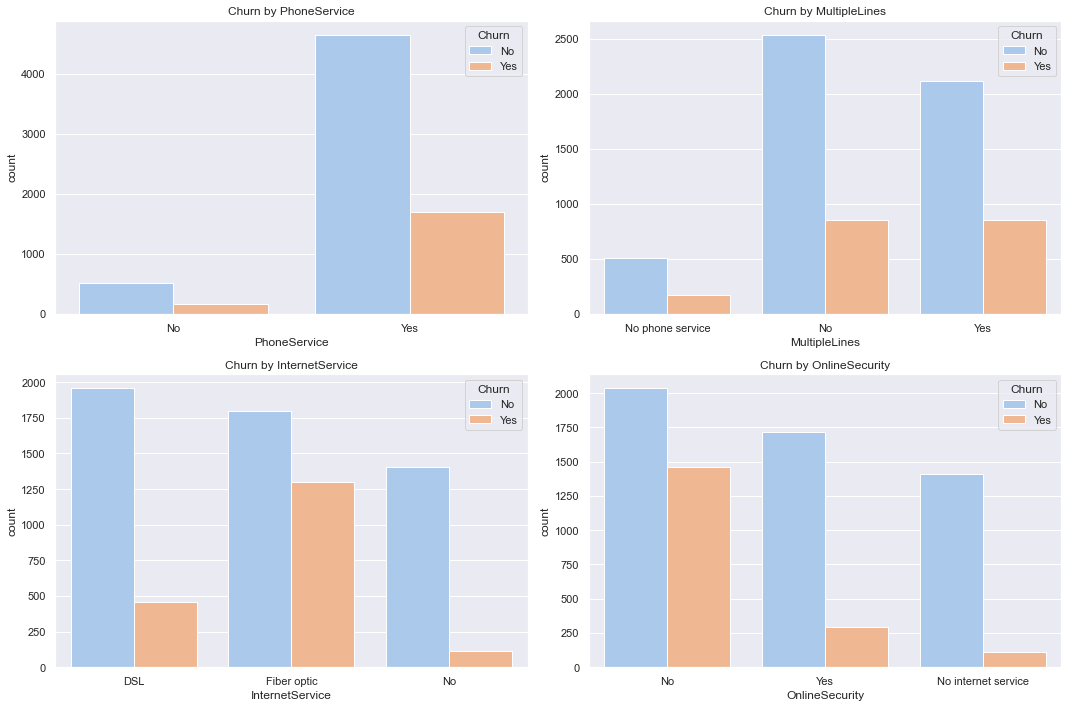

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))
churn_plot(ax1,'PhoneService')
churn_plot(ax2, 'MultipleLines')
churn_plot(ax3,'InternetService')
churn_plot(ax4,'OnlineSecurity')

plt.tight_layout()

The churn rate seems to be influences by fiber optic internet service. Are there any issues with this? People without online security are more likely to churn, perhaps we can offer them discounted online security?

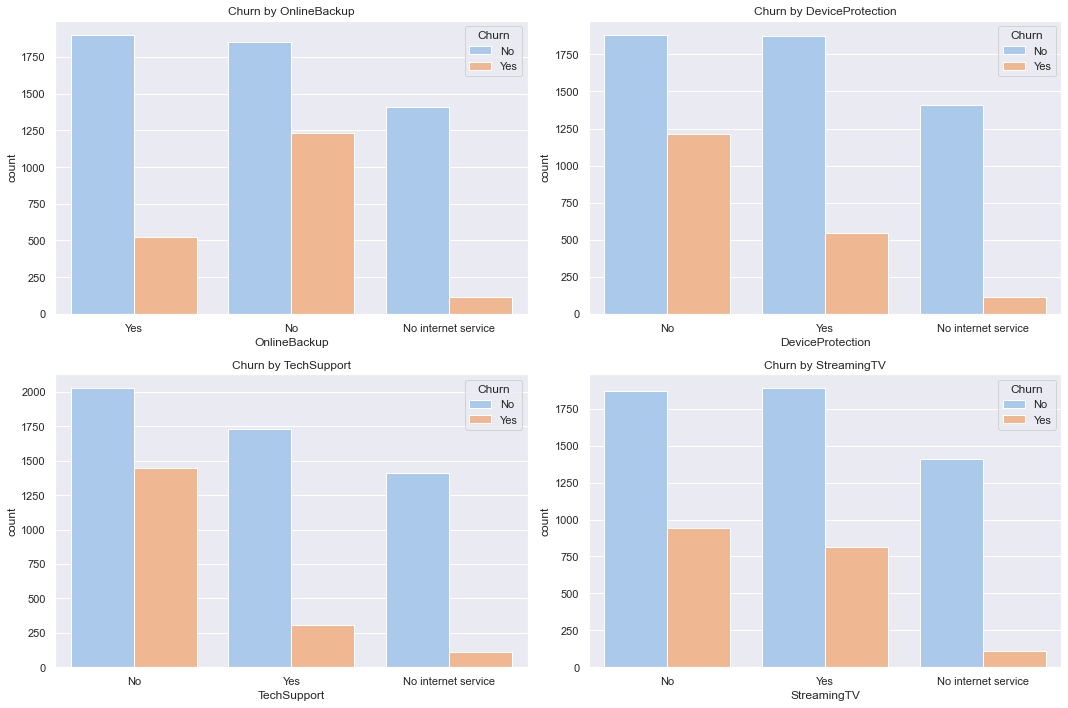

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))
churn_plot(ax1,'OnlineBackup')
churn_plot(ax2,'DeviceProtection')
churn_plot(ax3,'TechSupport')
churn_plot(ax4,'StreamingTV')

plt.tight_layout()

These plots show that the more add-ons people purchase the less likely they are to churn. An interesting insight. Streaming (movies and tv, see below) seem to not have much impact on the numbers, though.

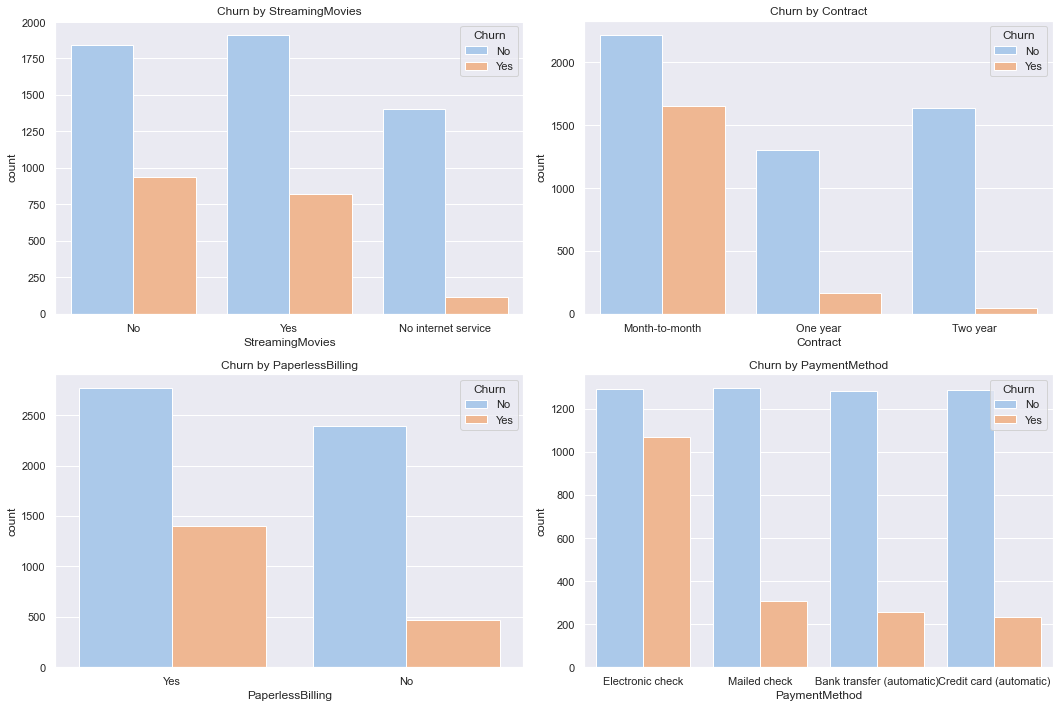

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))
churn_plot(ax1,'StreamingMovies')
churn_plot(ax2,'Contract')
churn_plot(ax3,'PaperlessBilling')
churn_plot(ax4,'PaymentMethod')

plt.tight_layout()

Longer contracts are less likely to churn, as expected. These people are committed and have likely already went through a phase of shorter contract.

In [25]:
# Make output (y) numeric instead of 'yes' or  'no' to check for correlation
df.loc[df.Churn=='No','Churn'] = 0 
df.loc[df.Churn=='Yes','Churn'] = 1
df['Churn']

customerID
7590-VHVEG    0
5575-GNVDE    0
3668-QPYBK    1
7795-CFOCW    0
9237-HQITU    1
             ..
6840-RESVB    0
2234-XADUH    0
4801-JZAZL    0
8361-LTMKD    1
3186-AJIEK    0
Name: Churn, Length: 7032, dtype: object

<AxesSubplot:xlabel='tenure', ylabel='Churn'>

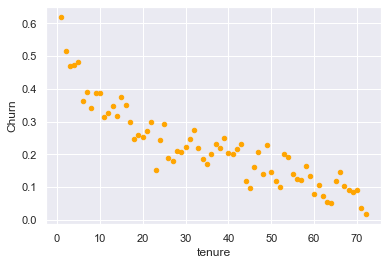

In [26]:
df.groupby('tenure').Churn.mean().reset_index().plot(x='tenure', y='Churn',kind='scatter', c='orange')

There is a clear negative correlation between tenure and churn, likely the same reason people with longer contracts are more likely to stay. 

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Churn'>

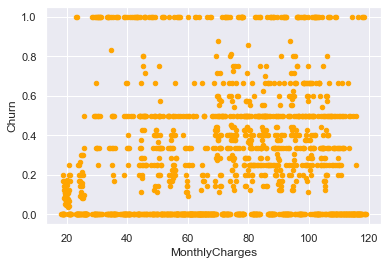

In [27]:
df.groupby('MonthlyCharges').Churn.mean().reset_index().plot(x='MonthlyCharges', y='Churn',kind='scatter', c='orange')

There is no correlation when looking at monthly charges and churn.

# 2. Feature Engineering

In [46]:
X = df.drop('Churn', axis=1)
y = df['Churn']
y=y.astype('int')

In [47]:
X.shape, y.shape

((7032, 18), (7032,))

Let's oversample our target variable, as churners are underrepresented in the inital data set.

<AxesSubplot:xlabel='Churn', ylabel='count'>

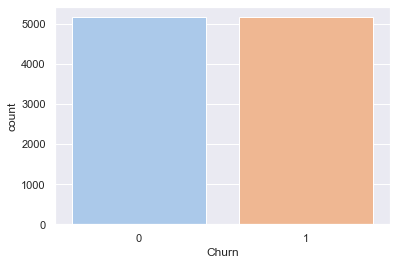

In [48]:
ros = RandomOverSampler(random_state=11)
X_resampled, y_resampled = ros.fit_resample(X, y)

sns.countplot(x=y_resampled)


In [49]:
X_resampled.shape, y_resampled.shape

((10326, 18), (10326,))

**One-hot encoding categorical variables**

In [50]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10326 entries, 0 to 10325
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            10326 non-null  object 
 1   SeniorCitizen     10326 non-null  int64  
 2   Partner           10326 non-null  object 
 3   Dependents        10326 non-null  object 
 4   tenure            10326 non-null  int64  
 5   PhoneService      10326 non-null  object 
 6   MultipleLines     10326 non-null  object 
 7   InternetService   10326 non-null  object 
 8   OnlineSecurity    10326 non-null  object 
 9   OnlineBackup      10326 non-null  object 
 10  DeviceProtection  10326 non-null  object 
 11  TechSupport       10326 non-null  object 
 12  StreamingTV       10326 non-null  object 
 13  StreamingMovies   10326 non-null  object 
 14  Contract          10326 non-null  object 
 15  PaperlessBilling  10326 non-null  object 
 16  PaymentMethod     10326 non-null  object

In [51]:
#SeniorCitizen is already between 0 and 1 and does not need to be encoded. MonthlyCharges and tenure are numerical by default.
X_resampled = pd.get_dummies(X_resampled, columns=['gender', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       ], drop_first=True)
X_resampled.head(2)

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,34,56.95,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


## 3. Models

**3.1 Time for our train/test split**

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size = 0.2, random_state=11)

In [55]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8260, 29), (8260,), (2066, 29), (2066,))

**3.2 Random Forest model**

We start with a random forest model as it is generally a very solid model and can give us a good baseline outcome.

In [58]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=11)

In [59]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3)

In [65]:
y_pred_rf = rf.predict(X_test)

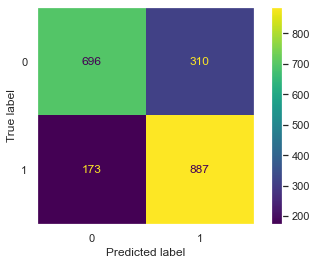

In [68]:
cm = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot()

In [73]:
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.7539951573849879, 0.7662149080348499)

In [70]:
classification_random_forest = (classification_report(y_test, y_pred_rf))
print(classification_random_forest)

              precision    recall  f1-score   support

           0       0.80      0.69      0.74      1006
           1       0.74      0.84      0.79      1060

    accuracy                           0.77      2066
   macro avg       0.77      0.76      0.76      2066
weighted avg       0.77      0.77      0.76      2066



Our base model does not perform too well, we do want above 80% accuracy. Let's try some hyperparameter finetuning.

**3.3 Applying GridSearch to RandomForest model**

In [77]:
grid = GridSearchCV(rf,
        param_grid={'max_depth': [2, 4, 8, 10], 'n_estimators':[10, 20, 50, 110]},
        scoring='accuracy',
        n_jobs=1,
        cv=5,
        return_train_score=True
        )
grid.fit(X_train, y_train)
gridcv_df = pd.DataFrame(grid.cv_results_)

print("all scores      :")
print(gridcv_df)

print("\nbest score      :", grid.best_score_)

all scores      :
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.021988      0.009750         0.002212        0.000163   
1        0.030088      0.000854         0.002971        0.000094   
2        0.072155      0.001255         0.005659        0.000054   
3        0.148033      0.002452         0.010703        0.000112   
4        0.019577      0.000375         0.002114        0.000033   
5        0.036330      0.000454         0.003186        0.000017   
6        0.086908      0.000845         0.006445        0.000110   
7        0.188681      0.001942         0.012782        0.000057   
8        0.026731      0.000458         0.002562        0.000013   
9        0.050300      0.000264         0.004090        0.000028   
10       0.122936      0.000745         0.008732        0.000075   
11       0.266180      0.001621         0.017807        0.000082   
12       0.029970      0.000427         0.002784        0.000017   
13       0.056909      0.00062

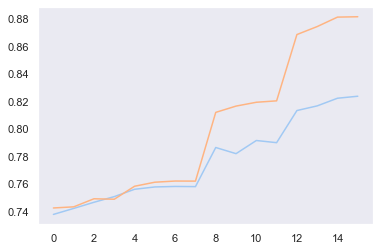

In [82]:
plt.plot(gridcv_df['mean_test_score'], label='Mean Test Score')
plt.plot(gridcv_df['mean_train_score'], label='Mean Train Score')

In [89]:
gridcv_df.sort_values('mean_test_score', ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
15,0.320814,0.012323,0.02154,0.000657,10,110,"{'max_depth': 10, 'n_estimators': 110}",0.83293,0.802663,0.823245,...,0.823608,0.010974,1,0.881205,0.882264,0.881205,0.882113,0.880297,0.881416,0.000714


By using a random forest model with max_depth = 10 and n_estimators=110, we get an accuracy score of 0.82 for the test set.

<AxesSubplot:>

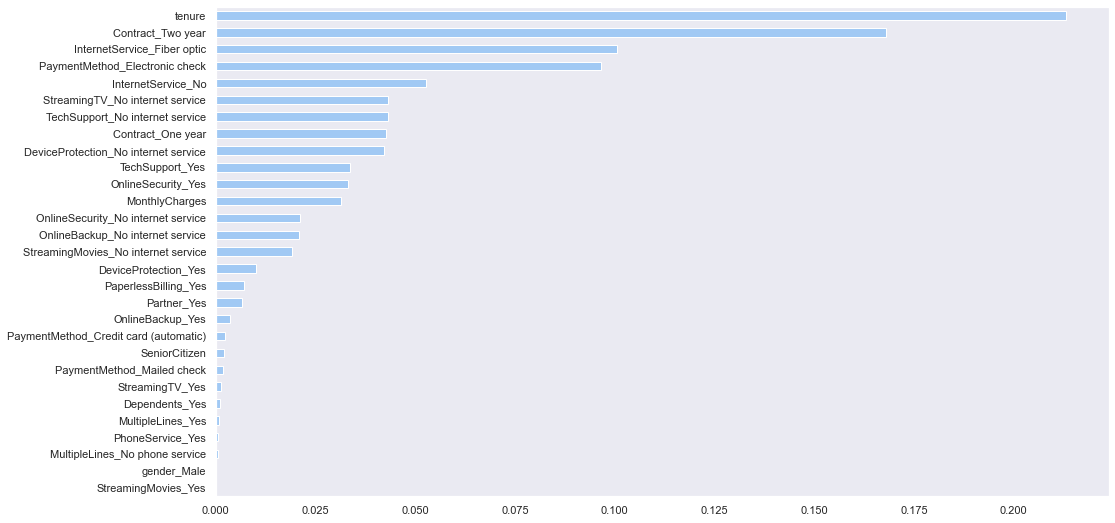

In [98]:
feature_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values()
plt.figure(figsize=(16,9))
feature_imp.plot(kind='barh')

The feature importances for this model show that tenure and contract length (the longer, the better) are the main drivers of classification. We keep this in mind.

**3.4 Scaling**

Finally, we want to try running the model with scaled columns.

In [146]:
scaler = StandardScaler()
X_standard = scaler.fit_transform(X_resampled)

In [147]:
X_standard_train, X_standard_test, y_train, y_test = train_test_split(X_standard,y_resampled, test_size = 0.2, random_state=11)

In [148]:
rf_2 = RandomForestClassifier(n_estimators=110, max_depth=10, random_state=11)

In [149]:
rf_2.fit(X_standard_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=110, random_state=11)

In [150]:
y_pred_rf2 = rf_2.predict(X_standard_test)

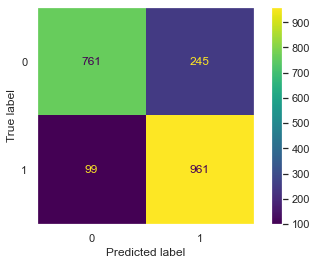

In [151]:
cm = confusion_matrix(y_test, y_pred_rf2, labels=rf_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_2.classes_)
disp.plot()

In [152]:
rf_2.score(X_standard_train, y_train), rf_2.score(X_standard_test, y_test)

(0.8746973365617433, 0.8334946757018393)

At first sight, this looks slightly better than our first random forest model. Let's run gridCV again to confirm it actually is the best model.

In [113]:
grid = GridSearchCV(rf_2,
        param_grid={'max_depth': [2, 4, 8, 10], 'n_estimators':[10, 20, 50, 110]},
        scoring='accuracy',
        n_jobs=1,
        cv=5,
        return_train_score=True
        )
grid.fit(X_standard_train, y_train)
gridcv_df = pd.DataFrame(grid.cv_results_)

print("all scores      :")
print(gridcv_df)

print("\nbest score      :", grid.best_score_)

all scores      :
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.015781      0.001573         0.001436        0.000125   
1        0.028552      0.000318         0.002308        0.000039   
2        0.071424      0.000465         0.005049        0.000049   
3        0.154668      0.001580         0.010558        0.000337   
4        0.019346      0.000210         0.001565        0.000022   
5        0.036413      0.000215         0.002653        0.000011   
6        0.111865      0.041424         0.006819        0.001590   
7        0.196028      0.000702         0.012677        0.000261   
8        0.026588      0.000119         0.002034        0.000013   
9        0.051262      0.000232         0.003588        0.000008   
10       0.128642      0.002310         0.008355        0.000092   
11       0.278810      0.000950         0.017723        0.000047   
12       0.030038      0.000232         0.002281        0.000013   
13       0.058741      0.00039

In [114]:
gridcv_df.sort_values('mean_test_score', ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
15,0.319275,0.001173,0.020579,0.0001,10,110,"{'max_depth': 10, 'n_estimators': 110}",0.831719,0.80569,0.820218,...,0.824576,0.010564,1,0.881659,0.883475,0.882718,0.884231,0.882415,0.8829,0.000884


When applying cross validation and GridSearch, we can see that we have barely any changes after scaling the data. The best parameters stay the same.

## Conclusion

With our random forest model, we can predict with 82% accuracy whether any single customer will churn. The most important variables for the prediction appear to be tenure (the longer any given customer stays with us, the longer he will also not churn) and contract length (it is important to get customers into longer contracts to avoid churn).

Next steps would be to test other models such as SVM, logistic regression, boosted decision trees or even neural networks.